## Challenge

The challenge is to generate adversarial examples for the digit 2 and get them to reclassify as 6.

The rules specify TensorFlow but the ground rules say any language can be used, and if that's the case then I'm also assuming that means it's flexible on libraries as well. I use mainly Lasagne, a deep learning library built on Theano for Python because I have experience with it. Sorry if it's not that readable for you and I'm happy to clarify any of the code.

In [1]:
#importing the necessary packages
import sys
import os
import time

import numpy as np
import theano
import theano.tensor as T

import lasagne

WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 6: GeForce GTX TITAN X (CNMeM is enabled with initial size: 95.0% of memory, cuDNN 4007)


In [2]:
from six.moves import cPickle
import matplotlib.pyplot as plt
%matplotlib inline

## Loading up the MNIST data

In [3]:
def load_dataset():
    # We first define a download function, supporting both Python 2 and 3.
    if sys.version_info[0] == 2:
        from urllib import urlretrieve
    else:
        from urllib.request import urlretrieve

    def download(filename, source='http://yann.lecun.com/exdb/mnist/'):
        print("Downloading %s" % filename)
        urlretrieve(source + filename, filename)

    # We then define functions for loading MNIST images and labels.
    # For convenience, they also download the requested files if needed.
    import gzip

    def load_mnist_images(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the inputs in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=16)
        # The inputs are vectors now, we reshape them to monochrome 2D images,
        # following the shape convention: (examples, channels, rows, columns)
        data = data.reshape(-1, 1, 28, 28)
        # The inputs come as bytes, we convert them to float32 in range [0,1].
        # (Actually to range [0, 255/256], for compatibility to the version
        # provided at http://deeplearning.net/data/mnist/mnist.pkl.gz.)
        return data / np.float32(256)

    def load_mnist_labels(filename):
        if not os.path.exists(filename):
            download(filename)
        # Read the labels in Yann LeCun's binary format.
        with gzip.open(filename, 'rb') as f:
            data = np.frombuffer(f.read(), np.uint8, offset=8)
        # The labels are vectors of integers now, that's exactly what we want.
        return data

    # We can now download and read the training and test set images and labels.
    X_train = load_mnist_images('train-images-idx3-ubyte.gz')
    y_train = load_mnist_labels('train-labels-idx1-ubyte.gz')
    X_test = load_mnist_images('t10k-images-idx3-ubyte.gz')
    y_test = load_mnist_labels('t10k-labels-idx1-ubyte.gz')

    # We reserve the last 10000 training examples for validation.
    X_train, X_val = X_train[:-10000], X_train[-10000:]
    y_train, y_val = y_train[:-10000], y_train[-10000:]

    # We just return all the arrays in order, as expected in main().
    # (It doesn't matter how we do this as long as we can read them again.)
    return X_train, y_train, X_val, y_val, X_test, y_test

In [4]:
# Load the dataset
X_train, y_train, X_val, y_val, X_test, y_test = load_dataset()

## Finding ten images of 2

Specifically I am looking through the y_test variable, because the advesarial noise I am training it on was trained using the training set, so I don't want to use an overfit sample for testing.

In [5]:
two_indices = y_test == 2
two_samples = X_test[two_indices]

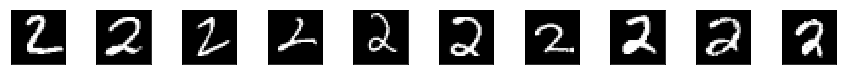

In [203]:
#Showing the first ten samples
fig, axes = plt.subplots(1, 10, figsize=(15, 1))
fig.subplots_adjust(hspace=0.3, wspace=0.3)

for i in range(10):

    axes[i].imshow(two_samples[i].reshape((28, 28)), cmap='gray')

    axes[i].set_xticks([])
    axes[i].set_yticks([])

# Show cells
plt.show()

## 1. Generating adversarial examples of specific images

In this first section I'm going to try to generate specific adversarial noise for the ten images shown above. This code is adapted from the Tensorflow code written by the Hvass Lab. 

The process will take a particular image with a particular desired class. It starts with a previously trained MNIST model and tries to take advantage of the backpropagation values to stress the nodes with the largest gradient to target the classification you want, in this case 6. 

### Loading previously trained MNIST model

In [10]:
# Model architecture
def build_cnn(input_var=None):
    network = lasagne.layers.InputLayer(shape=(None, 1, 28, 28),
                                        input_var=input_var)
    
    #conv layer 1
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(5, 5),
        nonlinearity=lasagne.nonlinearities.rectify,
        W=lasagne.init.GlorotUniform('relu'))
    
    #max pooling layer 1
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    #conv layer 2
    network = lasagne.layers.Conv2DLayer(
        network, num_filters=32, filter_size=(3, 3),
        nonlinearity=lasagne.nonlinearities.rectify)
    
    #max pooling layer 2
    network = lasagne.layers.MaxPool2DLayer(network, pool_size=(2, 2))
    
    #Dense mapping to a fully connected layer with dropout (p=0.5)
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=256,
        nonlinearity=lasagne.nonlinearities.rectify)
    
    # A softmax output for digit classification
    network = lasagne.layers.DenseLayer(
        lasagne.layers.dropout(network, p=.5),
        num_units=10,
        nonlinearity=lasagne.nonlinearities.softmax)

    return network

In [ ]:
#Building the graph for classification 

#Loading pretrained parameters
with open('trained_params.pkl', 'rb') as f:
    params = cPickle.load(f)
    
# The input tensor variable
input_var = T.tensor4('inputs')

# network contains the returned Lasagne network, and sets all the parameters to the pretrained MNIST classification CNN
network = build_cnn(input_var)
lasagne.layers.set_all_param_values(network, params)

# A theano function that takes in an input tensor and outputs the digit classification
test_prediction = lasagne.layers.get_output(network)
output_fn = theano.function([input_var], test_prediction, axis=1)

In [106]:
#tensor variable for target output
target_var = T.ivector('targets')

prediction = lasagne.layers.get_output(network)
loss = lasagne.objectives.categorical_crossentropy(prediction, target_var)
loss = loss.mean()

grad = theano.grad(loss, input_var)
get_gradient = theano.function([input_var, target_var], grad)

probability_fn = theano.function([input_var], test_prediction)

In [108]:
probability_fn([image]).squeeze()

array([  2.41488169e-06,   9.12983669e-05,   9.99668717e-01,
         1.57807808e-04,   3.13743975e-10,   3.54645535e-10,
         2.74187755e-07,   3.40783712e-09,   7.95280284e-05,
         2.99974906e-11], dtype=float32)

In [101]:
grad = get_gradient([image], [6])
print(grad.shape)
print(grad.squeeze().shape)

(1, 1, 28, 28)
(28, 28)


In [198]:
def find_adversarial_noise(image, target_class, debug=False):
    
    #Setting up training variables
    noise_limit = 0.35
    max_iter = 500
    required_score = 0.9
    
    #Running the image through the network to obtain the true classification
    true_class = output_fn([image])
    
    #Initialize noise to zero
    noise = 0
    
    #Optimize the noise to mis-classify the input image
    for i in range(max_iter):
        if i % 10 == 0:
            
            #Finds the noisy image and clips the image to make sure all the values are within the range of the original
            # MNIST images
            noisy_image = image + noise
            noisy_image = noisy_image.clip(0, 1)
            
            pred = probability_fn([noisy_image]).squeeze() #has the prediction probabilities of the input
            grad = get_gradient([image], [target_class]).squeeze() #outputs a set of 28x28 gradients
            
            # The gradient has the change to each input needed to increase the probability of the target class
            # We calculate the maximum gradient to choose a step size. 
            grad_max = np.abs(grad).max()
            
            # Setting the lower limit of grad_max
            if grad_max < 1e-10:
                grad_max = 1e-10
                
            # This ensures that at least one pixel will change by 0.05
            step_size = 0.1 / grad_max
            
            # Getting the probabilites for the predicted and target class
            score_pred = pred[true_class]
            score_target = pred[target_class]
            
            # Outputting training information
            if debug:
                print "Iteration: {}".format(i)
                print("The source class has an output probability of {:.2f}%".format(score_pred[0]* 100))
                print("The target class has an output probability of {:.2f}%".format(score_target* 100))
                print("The gradient min: {} max: {} stepsize: {}".format(grad.min(), grad.max(), step_size))
                print("")
                
            if score_target < required_score:
                noise -= step_size * grad
                
                #Clip the noise so it's not changing the image 2 much
                noise = noise.clip(-noise_limit, noise_limit)
            else:
                break
            
    return noise

### Using the function generate noise patterns for MNIST

Plotting the returned noise pattern that achieved an over 90% classification score for the adversarial example. The code I was looking at had a much faster conversion and achieved better misclassification rates but they were using a natural image dataset with 299 x 299 images. My hypothesis would be that with the larger dimensionality, you can create larger disturbances in the layers with smaller weights since the summation of a larger number of small weights is still significant. With the MNIST there's only 28 x 28 weights so you have to modify each one significantly more to achieve higher misclassifications.

In [176]:
noise = find_adversarial_noise(two_samples[0], 6, True)

[2]
Iteration: 0
The source class has an output probability of 98.04%
The target class has an output probability of 0.27%
The gradient min: -1.17420339584 max: 1.09530448914 stepsize: 0.042582060465

Iteration: 10
The source class has an output probability of 99.91%
The target class has an output probability of 0.04%
The gradient min: -1.0366101265 max: 1.79587197304 stepsize: 0.0278416283291

Iteration: 20
The source class has an output probability of 96.69%
The target class has an output probability of 0.00%
The gradient min: -1.15683805943 max: 1.05653846264 stepsize: 0.0432212612583

Iteration: 30
The source class has an output probability of 99.89%
The target class has an output probability of 0.00%
The gradient min: -0.71994972229 max: 1.0368360281 stepsize: 0.0482236329033

Iteration: 40
The source class has an output probability of 72.87%
The target class has an output probability of 20.64%
The gradient min: -1.26420068741 max: 1.29820990562 stepsize: 0.0385145728617

Iteration

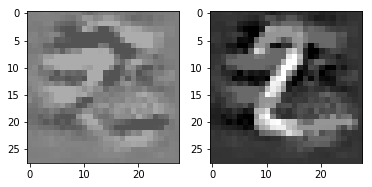

In [179]:
plt.subplot(121)
plt.imshow(noise, cmap='gray', vmin= -1, vmax = 1)
plt.subplot(122)
plt.imshow(noise + two_samples[0].squeeze(), cmap='gray')

### Plotting the images and the adversarial noise patterns

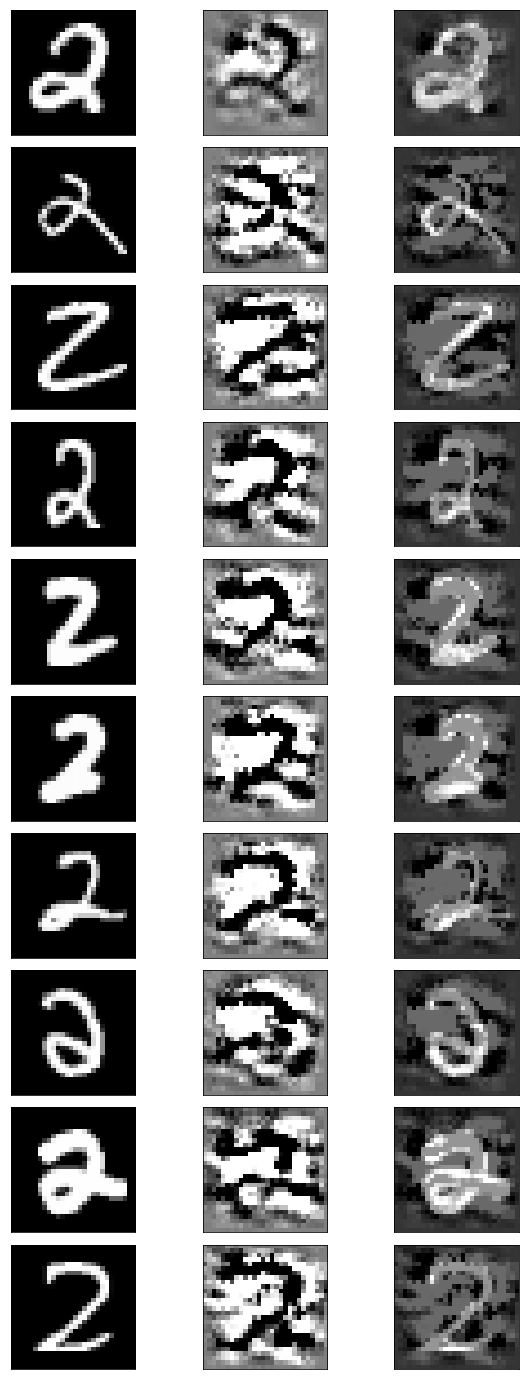

In [204]:
# Creating a figure of subplots
fig, axes = plt.subplots(10, 3, figsize=(10, 25))
fig.subplots_adjust(hspace=0.1, wspace=0.1)

for i, ax in enumerate(axes):
        
    image = two_samples[i + 10]
    noise = find_adversarial_noise(image, 6, False)

    image = image.reshape((28, 28))

    ax[0].imshow(image, cmap='gray')
    ax[1].imshow(noise, cmap='gray')
    ax[2].imshow(image + noise, cmap='gray')
    
    for a in ax:
        a.set_xticks([])
        a.set_yticks([])

# Show cells
plt.show()

In [206]:
for s in range(10, 20):
    
    image = two_samples[i]
    noise = find_adversarial_noise(image, 6, False)
    
    source_pred = output_fn([image])
    ad_pred = output_fn([image + noise])
    
    print("The original prediction was: {}, the prediction on the adversarial example was: {}".format(source_pred, ad_pred))

The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [7], the prediction on the adversarial example was: [6]
The original prediction was: [2], the prediction on the adversarial example was: [6]
The original prediction was: [7], the prediction on the adversarial example was: [6]


### Admittedly, the reason why I used images samples 10-19 instead of 0-9 was because in the first ten examples, two of instances misclassified to 8 instead of 6.

## 2. Generating adversarial noise for all images

Previously we generated examples only for specific images. Therefore the adversarial noise for one instance might not work when summed with another image. In this section we generate noise that can be applied to any MNIST image to misclassify it to a 6, including 2's. I didn't want to make this notebook too long, so the training for the noise is found in the "Adversarial Noise with MNIST" notebook also found in this directory. We essentially start off with a matrix of 0 for noise and train the noise using a classic CNN architecture. The noise is also regularized using L2.

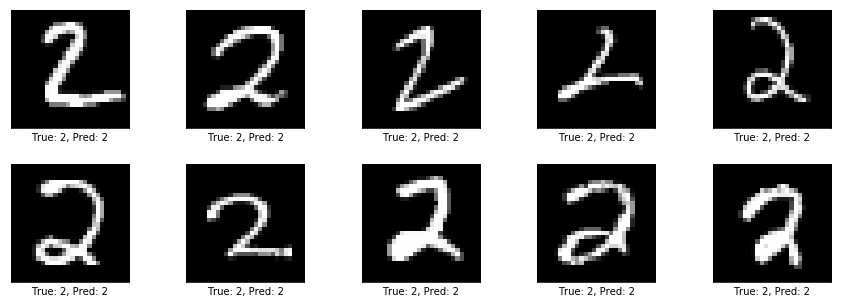

In [89]:
plot_images(two_samples[:10], 2, 5, [2 for i in range(10)], pred[:10])

## Loading the adversarial noise and generating predictions

In [208]:
# Loading the adversarial noise
with open('adversarial_6.pkl', 'rb') as f:
    noise = cPickle.load(f)

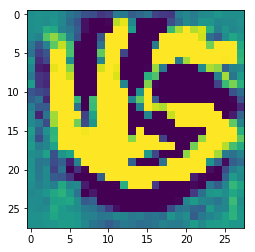

In [211]:
# Plot of the generated adversarial noise
plt.imshow(noise[0,:,:])

In [90]:
pred = output_fn(two_samples + noise)

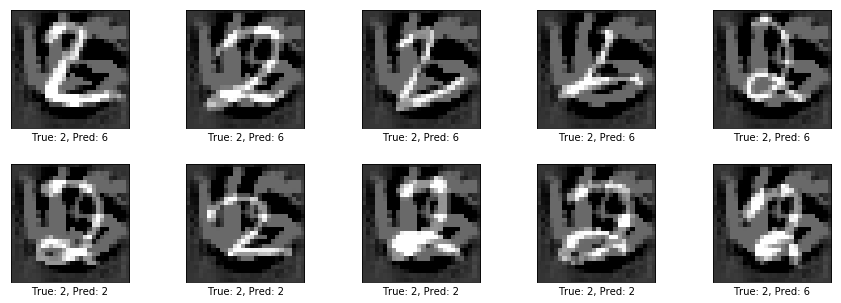

In [91]:
plot_images(two_samples[:10] + noise, 2, 5, [2 for i in range(10)], pred[:10])

### In this example, the classifier goes from predicting 100% of the images correctly to misclassifying 70% of the images, predicting them instead as 6. It is also possible of course to just select ten examples that misclassify as shown below. The images are visibly different than the original images, but at the same time don't nessarily resemble a 6. To a human observer, they would still likely call most of these samples a 2.

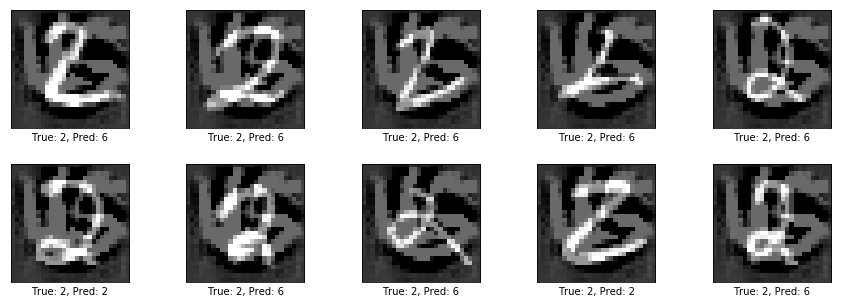

In [92]:
selected_indices = np.array([0, 1, 2, 3, 4, 5, 9, 11, 12, 13])
plot_images(two_samples[selected_indices] + noise, 2, 5, [2 for i in range(10)], pred[selected_indices])

### Discussion

This challenge was really interesting, and exposes a pretty simplistic flaw in a a lot of machine learning algorithms and these sorts of issues will definitely need to be addressed especially as deep learning systems are applied to more complex and serious tasks like self-driving cars or generating radiology annotations. Again I think my results with the MNIST set weren't as good as some of the results I read about, and it is possibly due to the small dimensionality of the data. Also it would've been easier to generate adversarial examples for simple linear classifiers instead of convolutional neural networks. 

I'd like to build a generative model for adversarial training with the MNIST set later on, which is another really interesting associated field of research. 